In [9]:
import numpy as np
import typing 
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections.abc import Callable
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.datasets import make_blobs
import copy
from sklearn.preprocessing import MinMaxScaler

In [226]:
def RBF(sigma: float = 1):
    def kernel(x: np.ndarray, y: np.ndarray):
        expo = -(np.sum((x[:,None,:] - y[None,:,:])**2, axis = -1))/(2*sigma) #Sum along the data dimension
        return np.exp(expo)
    return kernel

def Linear():
    def kernel(x: np.ndarray, y: np.ndarray):
        if isinstance(x, list):
            x = np.array(x)
        if isinstance(y, list):
            y = np.array(y)
        return x @ y.T
    return kernel

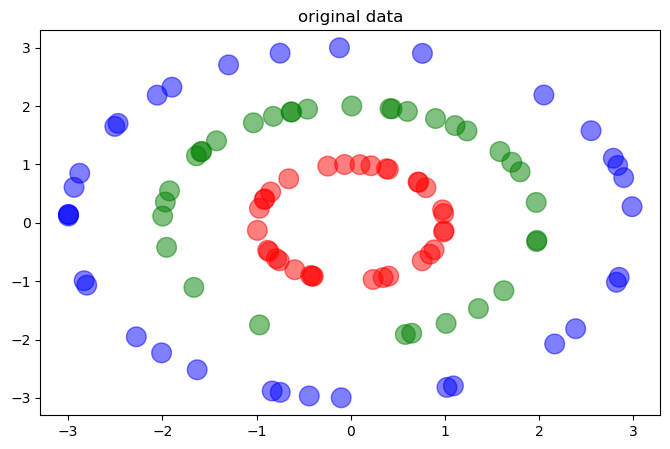

In [11]:
file = open('data/pca_datasets', 'rb')
from utils.utils import scatter_label_points
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']

scatter_label_points(train_set['x'], train_set['y'], title='original data')

# Hierarchical clustering

Data points are clusterized together via a quantity called *similarity*, or equivalentrly *dissimilarity*. The pair of cluster with the largest similarity (or equivalently lowest similarity) are merged together to form a new cluster constituted of the union of particles composing each of the parents cluster.

I only considered agglomerative hierarchical clustering here, that is, I start with numerous dispatched clusters and group them together via a certain metric until one cluster remains.

A very important property is that **the similarity of merging clusters is growing as the number of clusters decreases**. One often has the relationship: $D = 1 - S$, that is, a high dissilimarity is equivalent to a low similarity and conversely, a low dissimilarity is equivalent to a high similarity. A popular choice to estimate the dissimilarity between two clusters is to choose a *distance*. There exists a large pannel, I coded a few below. See [1] for a list of linkage between two clusters. Linkage is a synonym of similarity here. Note that dissimilarity is not a distance, because even for two identical clusters, it can be non-null for certain dissimilarity measure such as *CLINK* for example.


The time complexity of Hierarchical clustering is $\mathcal{O}(N^3)$ if one uses a matrix to store the dissimilarity between all pairs of clusters. A min-heap yields a $\boxed{\mathcal{O}(N^2)}$ time complexity, so the overhead of dealing with it is clearly worth it here. This is due to the fact that, for a numpy $N \times N$ matrix without particular structure, it takes $\mathcal{O}(N^2)$ to find the smallest dissimilarity, one has to search for all of them. However, it is $\mathcal{O}(1)$ for a heap.

**An important remark**: The previous paragraph does not take into account the time spent in building the initial heap. It involves computing $\frac{N(N-1)}2 \sim \mathcal{O}(N^2)$ distances stored into a vector with as much entries, and then heapify it. It is well know that heapifying a vecor of size $M$ scales in time as $\mathcal{O}(M\log(M))$. Therefore, it takes here $\mathcal{O}(N^2\log(N^2)) = \mathcal{O}(2N^2\log(N))$ steps supplementary the whole starting heap. At the end, the initialization phase scales as $\boxed{\mathcal{O}(N^2\log(N))}$, which is greater than the main phase of the algorithm. 

In a nutshell, if the initialization phase is taken into account in the calculation, the algorithm runs in $\mathcal{O}(N^2\log(N))$ and not $\mathcal{O}(N^2)$.

In the code, the vector $Z$ encodes the **linkage matrix**, describing the sequential agglomeration of clusters together. Let $N_b$ the final number of cluster and $N$ the number of elements. The vector $Z$ should be of size $(N - N_b) \times 4$. At $\text{i}$-th iteration, the new cluster has the id $N+i$, located at the $\text{i}$-th row. The first two indexes are the parent's cluster $\text{id}$. The third entry is the dissimilarity at creation and the fourth entry is the number of particles within. As said above, the dissimilarity should be a decreasing sequence with clusters merging together.

[1]https://en.wikipedia.org/wiki/Hierarchical_clustering#Cluster_Linkage

In [ ]:
@dataclass
class Cluster:
    """
    Class designed to represent a cluster. A cluster is a list of variable length of particles, an Id, and the dissimilarity at its creation.
    """
    particles: np.ndarray[np.ndarray]
    nb_particle : int
    cluster_id: int
    diss_creation: float = 0

    @staticmethod
    def merge(A, B, id: int):
        """
        Merge two clusters into one.
        id (int): It is the ID of the newly formed cluster.
        """
        N = len(A.particles) + len(B.particles)
        C = Cluster(np.concatenate((A.particles, B.particles), axis=0), N, id)
        return C

    def inter_variance(self):
        """
        Compute efficiently the variance of a cluster
        """
        return np.sum(np.mean((self.particles - np.mean(self.particles, axis = 0))**2, axis = 0))

    def __len__(self):
        """
        Return the number of particles in the cluster.
        """
        return len(self.particles)

    @staticmethod
    def remove(Clusters_Id: np.ndarray[int], idx_to_rm: tuple[int]):
        Id = []
        for i, id in enumerate(Clusters_Id):
            if id in idx_to_rm:
                Id.append(i)
        Clusters_Id = np.delete(Clusters_Id, Id)
        return Clusters_Id

In [ ]:
#Compute the shortest distance between the particles of clusters x and y
def dissim_min(x: np.ndarray[np.ndarray[float]]|Cluster, y: np.ndarray[np.ndarray[float]]|Cluster, dist: Callable = np.linalg.norm):
    """
    Also known as SLINK.
    """
    if isinstance(x, Cluster):
        x = x.particles
    if isinstance(y, Cluster):
        y = y.particles
    return np.min(dist(x[:,None,:] - y[None,:,:], axis = -1)) #Return the minimal distance between all couples of points.

#Compute the largest distance between the particles of clusters x and y
def dissim_max(x: np.ndarray[np.ndarray[float]]|Cluster, y: np.ndarray[np.ndarray[float]]|Cluster, dist: Callable = np.linalg.norm):
    """
    Also known as CLINK
    """
    if isinstance(x, Cluster):
        x = x.particles
    if isinstance(y, Cluster):
        y = y.particles
    return np.max(dist(x[:,None,:] - y[None,:,:], axis = -1))

def dissim_avg(x: np.ndarray[np.ndarray[float]]|Cluster, y: np.ndarray[np.ndarray[float]]|Cluster, dist: Callable = np.linalg.norm):
    if isinstance(x, Cluster):
        x = x.particles
    if isinstance(y, Cluster):
        y = y.particles
    return np.mean(dist(x[:,None,:] - y[None,:,:], axis = -1))

def dissim_centroids(x: np.ndarray[np.ndarray[float]]|Cluster, y: np.ndarray[np.ndarray[float]]|Cluster, dist: Callable = np.linalg.norm):
    if isinstance(x, Cluster):
        x = x.particles
    if isinstance(y, Cluster):
        y = y.particles
    return dist(np.mean(x, axis = 0), np.mean(y, axis = 0))**2

def dissim_ward(x: np.ndarray[np.ndarray[float]], y: np.ndarray[np.ndarray[float]], dist: Callable = np.linalg.norm):
    #TO DO
    pass

import heapq
class Hierarchical_Clustering:
    def __init__(self, dissimilarity: Callable = dissim_min, distance: Callable = np.linalg.norm):
        """
        nb_class (int): Nb of cluster.
        similarity (Callable): Compute the similarity between two clusters.
        distance (Callable): Compute the distance between two points.
        """

        self.distance = distance #Distance between two points.
        self.dissimilarity = dissimilarity

        self.clusters = np.array([])

        self.is_fitted = False

    def Build_Diss_heap(self, particles):
        """
        Built the whole Dissimilarity heap. In theory, it should be called only at initialization.
        """
        N = len(particles)
        Diss_heap = []
        for i in range(N):
            for j in range(i+1, N):
                Diss = self.dissimilarity(self.clusters[i].particles, self.clusters[j].particles)
                Diss_heap += [(Diss, i, j)] #Add the dissimilarity between cluster i and cluster j.
        heapq.heapify(Diss_heap)
        return Diss_heap

    def check_growing_sequence(self):
        """
        Check that the dissimilarity between two merging clusters decrease with the number of cluster.
        """
        k = self.Z[0, 2]
        for i in self.Z[1:, 2]:
            if i < k:
                raise ValueError("Dissimilarity at cluster creation should be a decreasing sequence.")
            k=i

    @staticmethod
    def remove_clusters(heap_Diss: heapq, clusters_id: tuple[int]):
        """
        This static method should remove all pair of clusters containig at least an Id within clusters_id from the heap. 
        This is performed in-place.
        Args:
            heap_Diss (heap): Heap listing the dissimilarity between all pairs of cluster. The first element is the pair of cluster with the highest similarity.
            clusters_id (tuple[int]): tuple of cluster id to remove from the heap.
        Return:
            A heap.
        """
        Idx = []
        for k, (_, i, j) in enumerate(heap_Diss):
            if i in clusters_id or j in clusters_id:
                Idx.append(k)
        heap_Diss = [x for i, x in enumerate(heap_Diss) if i not in Idx]
        return heap_Diss

    def update_heap(self, heap_Diss: heapq, Cluster_Id: list, clusters_to_remove: tuple[int], Cluster_to_add: Cluster):
        """
        The heap should be updated, that is, the parent cluster should be removed and its two offsprings should be added.
        The entries between the parent clusters and the other ones should be discarded of the heap. On an other hand, one needs to compute
        the similarity between the offspring cluster and all other ones. At the end, it results in a shorter heap.

        Args:
            heap_Diss (heap): Heap listing the dissimilarity between all pairs of cluster. The first element is the pair of cluster with the highest similarity.
            Cluster_Id (tuple[int]): Tuple of Id clusters at the current level of the hierarchical clustering.
            clusters_to_remove (tuple[int]): Tuple of Id clusters to remove from the heap.
            Cluster_to_add (Cluster): Cluster who should be added to the heap. The similarity between this cluster and all others should be computed and added to the heap.
        Return:
            A heap up to date to the current state of clusters.
        """
        heap_Diss = self.remove_clusters(heap_Diss, clusters_to_remove)

        New_Diss = []
        for id in Cluster_Id:
            New_Diss.append((self.dissimilarity(Cluster_to_add, self.clusters[id]), id, Cluster_to_add.cluster_id))
            if id == Cluster_to_add.cluster_id:
                print(self.dissimilarity(Cluster_to_add, self.clusters[id]))
        heap_Diss.extend(New_Diss)

        heapq.heapify(heap_Diss)
        return heap_Diss

    def fit(self, particles: np.ndarray[np.ndarray]):
        """
        Implementation of hierarchical clustering for a set X of particles. Each clusters newly formed will be stacked in the list clusters.
        I implement here the more popular agglomerative approach.
        """

        N = len(particles)
        Clusters_Id = np.arange(N)
        self.Z = np.empty((N - 1, 4))

        for i, p in enumerate(particles):
            cluster = Cluster(np.array([p]), i, 1)
            self.clusters = np.append(self.clusters, cluster)

        heap_Diss = self.Build_Diss_heap(particles)

        for idx in range(N - 1):

            #Find the pair minimizing disimilarity (or equivalently, maximizing the similarity).
            Diss_min, i_min, j_min = heap_Diss.pop(0)

            #Declare the newly formed cluster
            new_Cluster = Cluster.merge(self.clusters[i_min], self.clusters[j_min], id=int(N+idx))
            #Compute its dissimilarity at creation
            new_Cluster.diss_creation = Diss_min

            #Add the newly formed cluster
            self.clusters = np.append(self.clusters, new_Cluster)
            #Remove the parents cluster
            Clusters_Id = Cluster.remove(Clusters_Id, idx_to_rm=(i_min, j_min))

            #Update the heap
            heap_Diss = self.update_heap(heap_Diss, Clusters_Id, clusters_to_remove=(i_min, j_min), Cluster_to_add=new_Cluster)

            #Add the newly formed cluster
            Clusters_Id = np.append(Clusters_Id, int(N+idx))

            self.Z[idx] = np.array([i_min, j_min, new_Cluster.diss_creation, new_Cluster.nb_particle])

        self.check_growing_sequence()
        self.is_fitted = True

    def GetId(self, nb_cluster: int):
        """
        This method should return the list of cluster Id when there is nb_cluster in the hierarchical clustering.
        Args:
            nb_cluster (int): Number of cluster to consider.
        Return:
            A list of integer.
        """
        Id = []
        if nb_cluster == 1:
            Id.append(-1)
            return Id

        i, j, _, _ = self.Z[-1] #Get the ID of the two parents clusters
        Id.append(i); Id.append(j)
        if nb_cluster == 2:
            return Id

        for nb in range(2, nb_cluster):
            #Remove the latest cluster created, the one with the highest similarity, or equivalently the highest index.
            #The removed cluster is replaced with its two parents.
            if i > j: #Then i is the latest cluster created
                Id.remove(i)
            else: #j is the latest cluster created
                Id.remove(j)
            i, j, _, _ = self.Z[-nb]
        
            Id.append(i), Id.append(j) #Append the two parents
        return Id

    def plot_clusters(self, nb_cluster = 3, ax = None):
        """
        nb_cluster (int): Number of cluster one wants to display.
        ax: Axis on which to plot on.
        """
        assert self.is_fitted, "You did not fit your data set yet."
        assert nb_cluster > 0, "The number of cluster to plot should be a positive integer."

        color = ["grey", "brown", "orange", "olive", "green", "cyan", "blue"]

        Id = self.GetId(nb_cluster)
        if ax is not None:
            for i, idx in enumerate(Id):
                c = self.clusters[int(idx)]
                ax.scatter(c.particles[:,0], c.particles[:,1], color = color[i], label = f'cluster {i}')
            ax.legend()
            plt.show()
        else:
            for i, idx in enumerate(Id):
                c = self.clusters[int(idx)]
                plt.scatter(c.particles[:,0], c.particles[:,1], color = color[i], label = f'cluster {i}')
                plt.legend()
            plt.show()

    def dendrogram(self, title: str ="Dendrogram", *args, **kwargs):
        """
        x-axis is the label (or index) of all data points.
        y-axis is the similarity.
        """
        assert self.is_fitted, "You did not fit your data set yet."

        from scipy.cluster.hierarchy import dendrogram
        dendrogram(self.Z, *args, **kwargs)
        plt.title(title)
        plt.ylabel("Dissimilarity")

## Example

Does not work at all for this kind of dataset.

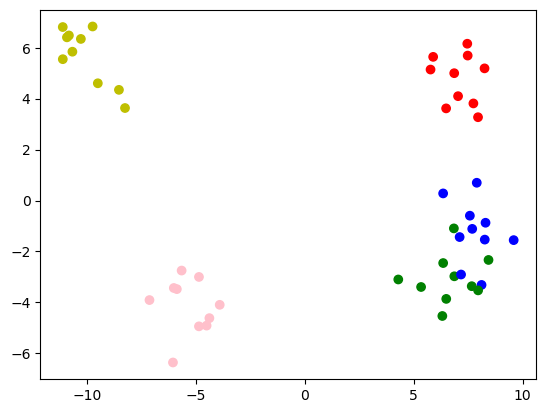

In [105]:
X, y = make_blobs(n_samples=50, n_features=2, centers=5)

color = np.array(['r', 'g', 'b', 'pink', 'y'])
plt.scatter(X[:,0], X[:,1], color = color[y])
plt.show()

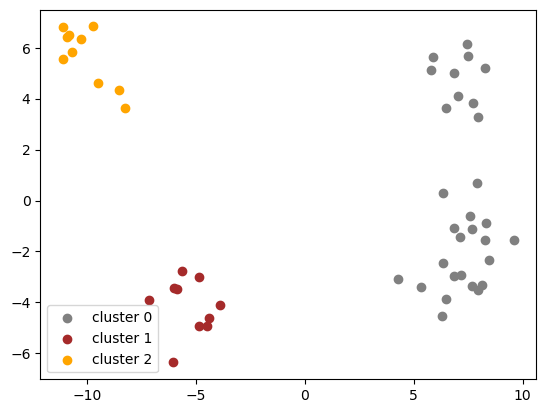

In [106]:
HC = Hierarchical_Clustering(dissimilarity=dissim_avg)

HC.fit(X)
HC.plot_clusters(3)

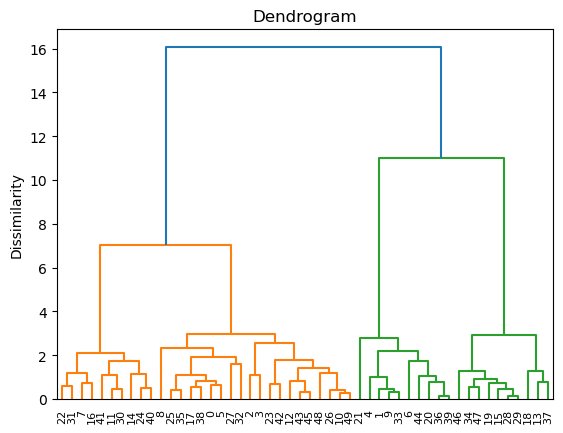

In [107]:
HC.dendrogram(title="Dendrogram")

One sees that for this kind of dataset, hierarchical clustering is not relevant at all.

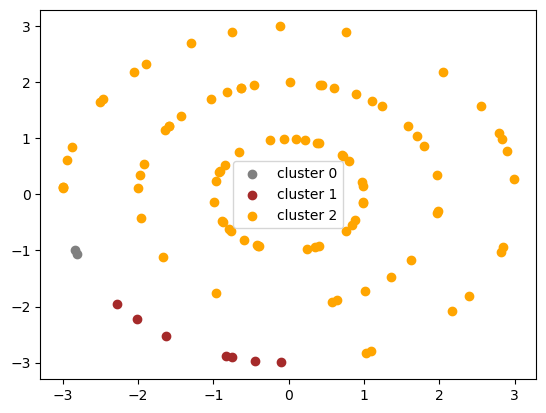

In [108]:
HC = Hierarchical_Clustering(dissimilarity=dissim_min)

HC.fit(train_set['x'])
HC.plot_clusters()

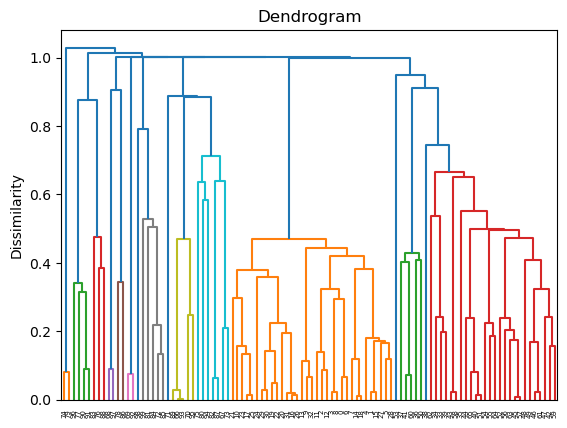

In [110]:
HC.dendrogram()

# DBSCAN

It stands for *Density-Based Spatial Clustering for Application with Noise*.

This clustering algorithm needs two parameters to run: $\epsilon$ and $N$. $\epsilon$ is the radius of the neighbouring ball $B_\epsilon$, and $N$ is the minimum number of points to be in a point neighboorhood to start a cluster (See below). This algorithm assumes the data set is globally homogeneous, It does not cope well with clusters of varying density.

The algorithm iterates over all unlabeled points of the array. At initialization, all points are unlabeled.

The clusters are formed in the following manner. Take an unlabelled point $P$ and apply the following steps.

1. Figure out the neighborhood of $P$. Two cases are possible:
    1. If the point $P$ has more than $N$ neighbors, then it is labelled as a `Core` points of a newly created cluster. Then, loop over all its neighbor. If a neighbor is labelled as a `Noise`, re-label it as a `Cluster`. Add each of its unlabelled neighbour to the new cluster, and find all its neighborhood. Once again, two scenarios are possible:
        1. If it has more than $N$ points in its neighborhood, then, it becomes a `Core` point. All of its neighborhood is added to the neighborhood of $P$. That way, the neighbouring `Core` points are concatenated into an unifying cluster.
        2. If it has less, it becomes a simple `Cluster` point.
    2. If $P$ has less than $N$ neighbours, then it is labelled as a `Noise` point. It might be relabelled as a `Cluster` point later though.
2. Take another unlabelled point.

In [ ]:
from typing import overload

@dataclass
class Point:
    pos: np.ndarray
    label: str|None
    cluster: int|None

    def dist(self, P):
        """
        Compute the euclidian distance between two points.
        """
        assert isinstance(P, (Point, list, np.ndarray)), "P should be a point, a list or a numpy array"
        if isinstance(P, Point):
            return np.linalg.norm(np.array(self.pos) - np.array(P.pos))
        else:
            P = np.array(P)
            np.linalg.norm(self.pos - P)

@dataclass
class Cluster:
    """
    Class designed to represent a cluster. A cluster is a list of variable length of particles, an Id, and the dissimilarity at its creation.
    """
    particles: np.ndarray[Point] #key-value between particle's id and its position
    nb_particle : int
    cluster_id: int
    diss_creation: float = 0

    def fuse(self, B):
        """
        Merge two clusters into one.
        """
        for b in B.particles:
            self.particles = np.append(self.particles, [b], axis = 0)
            self.nb_particle += 1
    
    def add(self, P: Point):
        """
        Add a point to the particles list.
        """
        self.particles = np.append(self.particles, P)
        self.nb_particle += 1

    def update_center(self):
        """
        Update the center of a cluster.
        """
        self.cluster_center = np.mean([point.pos for point in self.particles], axis=0)
    
    def inter_variance(self):
        """
        Compute efficiently the variance of a cluster
        """
        mean = np.mean([point.pos for point in self.particles], axis = 0) #Make the mean over the samples
        return np.sum([(point.pos - mean)**2 for point in self.particles])

    def __iter__(self):
        self.count = 0
        return self.particles

    def __next__(self):
        self.count += 1
        return self.particles[self.count - 1]
    
    def __len__(self):
        """
        Return the number of particles in the cluster.
        """
        return len(self.particles)


    def display(self):
        color = ["grey", "brown", "orange", "olive", "green", "cyan", "blue", 'r', 'g', 'purple']
        pos = np.array([point.pos for point in self.particles])
        try:
            plt.scatter(pos[:,0], pos[:,1], color = color[self.cluster_id], label = f'cluster {self.cluster_id}')
            plt.legend()
            plt.show()
        except IndexError:
            raise ValueError("Not enough colors stored in the list.")

In [ ]:
class DBSCAN:
    def __init__(self, min_pts: int, epsilon: float, distance: Callable = np.linalg.norm):
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.distance = distance
        self.nb_cluster = 0
        self.clusters = []
        self.history = []
        
        self.clusterized = []
        self.core = []
        self.noise = []

    def neighborhood(self, X: np.ndarray, P: np.ndarray):
        """
        Return all points in X whose distance w.r.t P is smaller than epsilon.
        """
        dist = self.distance(X - P, axis = 1)
        idx = list(np.where(dist <= self.epsilon)[0])
        return idx
    
    @staticmethod
    def init_dataset(X: np.ndarray[np.ndarray]):
        """
        A point object is instancied for each data point in X.
        """
        assert isinstance(X, np.ndarray), "X should be a numpy array"
        List_Points = []
        for x in X:
            List_Points.append(Point(x, None, None))
        return List_Points

    def fit(self, X: np.ndarray):
        """
        Build a set of cluster from X.
        """
        
        Points = self.init_dataset(X)

        for p in Points:
            if p.label != None: #If the chosen points was already picked before.
                continue
            else:
                Neighbours = self.neighborhood(X, p.pos)

                if len(Neighbours) >= self.min_pts: #Then 'p' is a cluster point
                    self.clusters.append(Cluster(p, 1, self.nb_cluster))
                    p.label = "Core"
                    p.cluster = self.nb_cluster

                    for idx in Neighbours:
                        n = Points[idx]
                        if n.label != None:
                            continue
    
                        n.cluster = self.nb_cluster
                        self.clusters[-1].add(n) #Add the neighbour to the latest created cluster
                        Neighbours_n = self.neighborhood(X, n.pos) #Find all neighbours of n
                        if len(Neighbours_n) > self.min_pts:
                            n.label = "Core"
                            self.core.append(n)
                            Neighbours += Neighbours_n #Add the neighbours of n to the neighborhood
                        else:
                            n.label = "Cluster"
                            self.clusterized.append(n)
                    self.nb_cluster += 1
                else:
                    p.label = "Noise"
                    self.noise.append(p)
            self.history.append(self.inertia())

    def display(self):
        #Display all clusters
        for cluster in self.clusters:
            cluster.display()
        #Display noise particles
        noise = np.array([point.pos for point in self.noise])
        if len(noise) != 0:
            plt.scatter(noise[:, 0], noise[:, 1], color = 'black', label = 'Noise')
            plt.legend()
            plt.show()

## Example

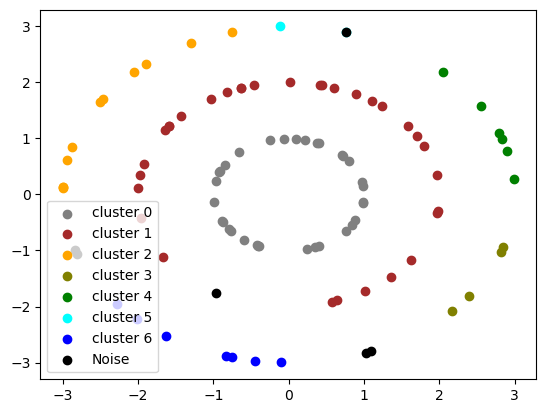

In [ ]:
db = DBSCAN(min_pts=3, epsilon=1)
db.fit(train_set['x'])

db.display()

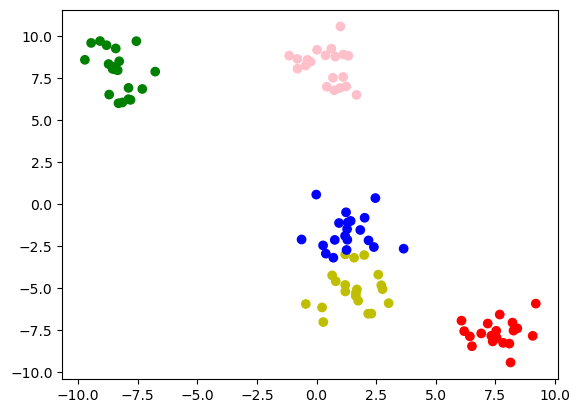

In [ ]:
X, y = make_blobs(n_samples=100, n_features=2, centers=5)

color = np.array(['r', 'g', 'b', 'pink', 'y'])
plt.scatter(X[:,0], X[:,1], color = color[y])
plt.show()

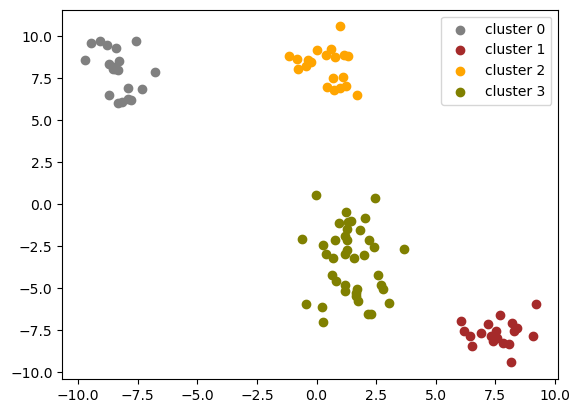

In [ ]:
db = DBSCAN(min_pts=3, epsilon=2)
db.fit(X)

db.display()

# OPTICS

It stands for *Ordering Points To Identify the Clustering Structure*. Like DBSCAN, it is a density-based clustering algorithm.

The basic idea is similar to what DBSCAN does, but solve one of its major flaws: DBSCAN is blind to data with highly varying density since $\epsilon$ is the same for all points. OPTICS offer a more fine grained view of the data distribution with the help of two quantities that I define below: the Core distance and the Reachibility distance. One introduces the two same parameters as DBSCAN: $N$ and $\epsilon$. However, $\epsilon$ is optional in OPTICS, that is, $\epsilon = +\infty$ if not defined. Note that OPTICS does not provide a set of well-defined cluster, it outputs a *reachibility plot*.

Note $N_\epsilon(P) = |\{x \, \backslash x \in B_\epsilon(P)\}|$, the number of points in the $\epsilon$-Neighborhood of $x$.

The **core distance** is defined as: 
$$
\boxed{
\text{Core\_dist}(P) =
\left\{
\begin{array}{ll}
    \text{dist}(P, \text{N-th neighbours}) & \text{if} \, N_\epsilon(P) \geq N, \\
    \text{None} & \text{otherwise}.
\end{array}
\right.}
$$
Hence, the core distance can be interpreted as the minimum distance for $P$ to be considered a core point. The smaller it is, the more dense is the cluster.

The **reachibility distance** is:
$$
\boxed{
\text{Reach\_dist}(P, Q) =
\left\{
\begin{array}{ll}
    \max(\text{Core\_dist}(P), \text{dist}(P, Q)) & \text{if} \, N_\epsilon(P) \geq N, \\
    \text{None} & \text{otherwise}.
\end{array}
\right.}
$$

$\epsilon$ is a parameter that let know how dense we want the clusters to be.
Two data structures needs to be implemented for the algorithm to work efficiently:
> 1. An ordered list: Each point $P$ has its own list. It lists in growing order the reachibility distance of every other points to $P$.
> 2. A min-heap: one for each cluster expansion, named `Order_Seeds` in the algorithm. It contains the candidates points for further future cluster expansion. I decided to implement the heap with the built-in librairy `heapq`. The entry for point $Q$ is of the form $(\text{Reach\_dist}(Q, P), Q)$ if the cluster is expanded around $Q$. The first element is therefore the one with the smallest $\text{Reach\_dist}$ to $P$.

At initialization, all points are unprocessed. We loop over all unprocessed points, and for each of them, call a procedure `ExpandClusterOrder`. 
The procedure `ExpandClusterOrder` expands a cluster around a point $P$. first by finding all its $\epsilon$-neighbours and then updating the heap by calling `Update`.
More precisely, it:
> 1. Sets the point $P$ as processed and compute its $\text{Core\_dist}$.
> 2. Finds all its $\epsilon$-neighbours.
> 3. Then, if $P$ is a core point:
>     1. Calls the procedure `Update` to fill up the heap `Order_Seeds`.
>     2. While the heap is not empty: take the first element (the point with smallest $\text{Reach\_dist}$), label it as `Processed`, compute its $\text{Core\_dist}$ and append it to `Ordered_List`.

The `Update` method fills up the heap `Order_Seeds` by applying the following instructions:
> 1. Loop over all neighbours $n$ of $P$.
> 2. If it has not been processed (i.e. it does not belong to another cluster already):
>    1. Compute its reachibility distance $d$ (to $P$). 
>       1. If $n$ was not assigned one beforehand, store it and append it into the heap.
>       2. If it was alreadry assigned one, update it and append it into the heap if $d$ is smaller.
> 3. Heapify the heap.

By definition, each object added to `Ordered_List` is processed.

**An important remark**: the output of the algorithm depends on the order at which the data is processed. For example, $(x_1, x_2, \cdots, x_N)$ may yield a different result than $(x_{\sigma(1)}, x_{\sigma(2)}\cdots, x_{\sigma(N)})$, where $\sigma$ is a permutation from $\llbracket 1, N\rrbracket ^N$ to $\llbracket 1, N\rrbracket ^N$.

[1][OPTICS, Ankert et al.](https://www.dbs.ifi.lmu.de/Publikationen/Papers/OPTICS.pdf)

In [ ]:
from typing import overload

@dataclass
class Point:
    pos: np.ndarray
    processed: bool
    cluster: int|None
    reach_dist: float|None
    core_dist: float|None

    def dist(self, P):
        """
        Compute the euclidian distance between two points.
        """
        assert isinstance(P, (Point, list, np.ndarray)), "P should be a point, a list or a numpy array"
        if isinstance(P, Point):
            return np.linalg.norm(np.array(self.pos) - np.array(P.pos))
        else:
            P = np.array(P)
            np.linalg.norm(self.pos - P)
            
#Take the same definition of cluster as DBSCAN.

In [226]:
import heapq

class OPTICS:
    def __init__(self, min_pts: int, epsilon: float | None, distance: Callable = np.linalg.norm):
        """
        If epsilon is None, then one sets it at infinity.
        """
        self.epsilon = epsilon
        if epsilon is None:
            self.epsilon = np.infty
        self.min_pts = min_pts
        self.distance = distance

        self.Ordered_List = []

        self.clusterized = []
        self.core = []

    def neighborhood(self, X: np.ndarray, P: np.ndarray|Point):
        """
        Return all points in X whose distance w.r.t P is smaller than epsilon.
        """
        if isinstance(P, Point):
            P = P.pos
        assert isinstance(P, np.ndarray), "P should be a Point or a numpy array."
        dist = self.distance(X - P, axis = 1)
        idx = list(np.where(dist <= self.epsilon)[0])
        return idx

    @staticmethod
    def init_dataset(X: np.ndarray[np.ndarray]):
        """
        A point object is instancied for each data point in X.
        """
        assert isinstance(X, np.ndarray), "X should be a numpy array"
        List_Points = []
        for x in X:
            List_Points.append(Point(x, False, None, None, None))
        return np.array(List_Points)

    def setCoreDistance(self, Neighbour: np.ndarray[np.ndarray], p: Point|np.ndarray):
        if len(Neighbour) < self.min_pts:
            return None
        if isinstance(p, Point):
            p = p.pos
        assert isinstance(p, np.ndarray), "p should be a Point object or a numpy array."
        Distance = np.linalg.norm(Neighbour - p, axis=-1)
        return np.sort(Distance)[self.min_pts - 1]

    def Update(self, Order_Seeds: list, Neighbours: np.ndarray, p: Point):
        """
        Update the heap Order_Seeds by looking at the neighbours of p.
        Args:
            Order_Seeds (heap): list to fill up and heapify.
            p (Point): point around which the cluster is expanded.
            Neighbours (np.ndarray): epsilon-Neighbours of p.
        Return:
            A heap.
        """
        c_dist = p.core_dist
        for i, n in enumerate(Neighbours):
            if not n.processed:
                new_r_dist = max(c_dist, n.dist(p))
                if n.reach_dist is None:
                    n.reach_dist = new_r_dist
                    heapq.heappush(Order_Seeds, (n.reach_dist, i, n))
                else:
                    if new_r_dist < n.reach_dist:
                        for k in Order_Seeds:
                            if k[0] == n.reach_dist:
                                k[0] = new_r_dist
                        n.reach_dist = new_r_dist
                        heapq.heapify(Order_Seeds)
        return 0

    def ExpandClusterOrder(self, X: np.ndarray[np.ndarray], Points: np.ndarray[Point], p: Point):
        """
        Args:
            X: array of the points positions.
            Points: array of points in the set.
            p: The point around which a cluster is expanded.
        """

        Neighbours = self.neighborhood(X, p) #Get the epsilon-neighborhood of 'p'
        p.processed = True
        p.reach_dist = None
        p.core_dist = self.setCoreDistance(X[Neighbours], p) #Find the Core distance of p
        Ordered_List_p = [p.reach_dist]

        Order_Seeds = [] #heap
        #If it is a core point
        if p.core_dist != None:
            self.Update(Order_Seeds, Points[Neighbours], p)
            while len(Order_Seeds) != 0: #While the heap is not empty
                _, _, obj = heapq.heappop(Order_Seeds)
                Neighbours = self.neighborhood(X, obj)
                obj.processed = True
                obj.core_dist = self.setCoreDistance(X[Neighbours], obj)
                Ordered_List_p.append(obj.reach_dist)
        return Ordered_List_p

    def fit(self, X: np.ndarray):
        """
        Build a set of clusters from X.
        Args: 
            X (np.ndarray: n x d): a list of data points in d dimension of space.
        """
        assert isinstance(X, np.ndarray), "X should be a Numpy array."
        Points = self.init_dataset(X)
        self.Ordered_List = []
        for p in Points:
            if not p.processed:
                self.Ordered_List.append(self.ExpandClusterOrder(X, Points, p)) #Expand a cluster around this point
        return 0

    def reach_plot(self, title="Reachibility Plot"):
        plt.figure(figsize=(5, 4))
        plt.tick_params(labelright=True)
        N = 0
        for i, Ordered_List_p in enumerate(self.Ordered_List):
            plt.plot(np.arange(N, N+len(Ordered_List_p)), Ordered_List_p, marker='o', linestyle="-")
            N += len(Ordered_List_p)
        plt.title(title + f" with $\epsilon = {self.epsilon}$ and $N={self.min_pts}$.")
        plt.ylabel("Reachibility")
        plt.show()

<>:123: SyntaxWarning: invalid escape sequence '\e'
<>:123: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_27215/1624762281.py:123: SyntaxWarning: invalid escape sequence '\e'
  plt.title(title + f" with $\epsilon = {self.epsilon}$ and $N={self.min_pts}$.")


## Example

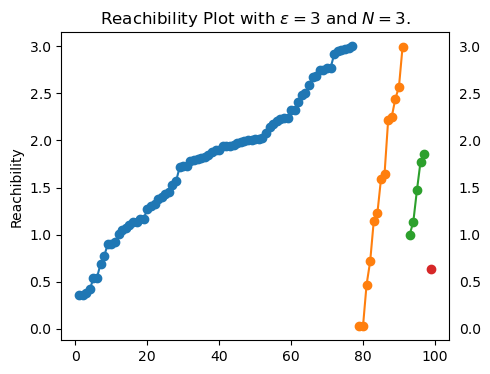

In [227]:
db = OPTICS(min_pts=3, epsilon=3)
db.fit(train_set['x'])

db.reach_plot()

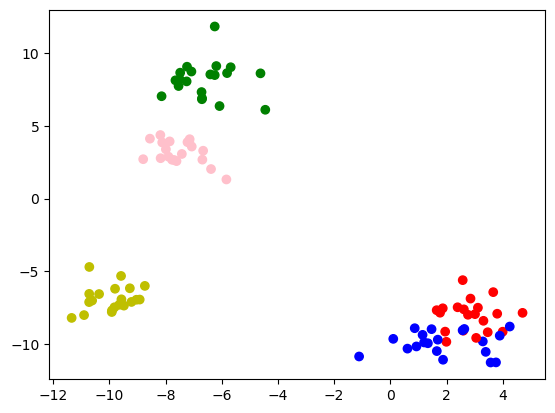

In [228]:
X, y = make_blobs(n_samples=100, n_features=2, centers=5)

color = np.array(['r', 'g', 'b', 'pink', 'y'])
plt.scatter(X[:,0], X[:,1], color = color[y])
plt.show()

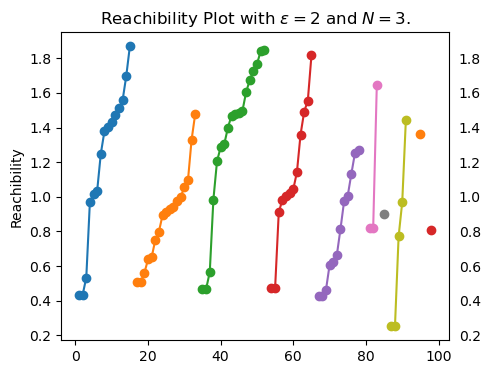

In [230]:
db = OPTICS(min_pts=3, epsilon=2)
db.fit(X)

db.reach_plot()

# KMEAN

Fait partie de la classe plus large des centroïdes. Pour un nombre fixe de centroïds, on applique l’algorithme de Lloyd (augmentée de **kmeans++**[1] pour initialiser les clusters).

Le problème d’optimisation général à résoudre est le suivant:
$$
\min\limits_{N_c \in \mathbb{N}^*} \min\limits_{\mathcal{C}_1, \cdots, \mathcal{C}_{N_c}} \sum_{i=1}^{N_c} \sum\limits_{x \in \mathcal{C}_i} d(x, \bar y_{i}),
$$
où $N$ est le nombre de point, $N_c$ le nombre de cluster, $\mathcal{C}_i$ est le $i$-ème cluster et $\bar y_{i} \in \mathbb{R}^d$ son centroid pour la distance $d$. $n_d$ est la dimension de l’espace considéré et $d$ une distance, ici $d(x, y) = ||x-y||^2_2$. Les clusters sont exclusifs, i.e. $\forall i, j \in \{1, \cdots, N_c\}$, $\mathcal{C}_i \cap \mathcal{C}_j = \emptyset$.
Il faut savoir que ce problème tels quel est très dur à résoudre, il fait partie de la classe des problèmes NP Hard. En général, on peut utiliser le BIC (Bayesian Information Criterion) pour déterminer le nombre de cluster adéquat. Si le nombre de cluster est fixé à l’avance, alors sa résolution devient beaucoup plus abordable.

L’algorithme de Floyd est un algorithme itératif pour rapidement trouver un minimum local. La quantité $\sum\limits_{i = 1}^N d(x_i, \bar x_{c(i)})$ est appelé *Inertie*, et l'objectif est de trouver les bons centroides qui minimisent une telle quantité.

L'algorithme de Lloyd consiste à alterner deux étapes, une d'assignement, et une autre de mise-à-jour. Supposons que l'on ait initialement $(y_1, \cdots, y_{N_c})$, le centre de chacun des clusters.

> 1. Etape d'Assignement: Pour chaque $i \in \llbracket 1, N \rrbracket$, calculer $c(i) = \argmin\limits_j\{||x_i - y_j||, j \in \llbracket 1, N_c \rrbracket\}$, c'est-à-dire, trouver le centroid le plus proche de $x_i$.
> 2. Etape de mise-à-jour: Pour chaque $i \in \llbracket 1, N \rrbracket$, calculer, $y_i = \frac1{N_{c_i}}\sum\limits_{x \in C_i} x$, où $C_i$ est l'ensemble des points dans le i-ème cluster.

Le problème du K-median correspond au cas où $d$ est la distance $L^1$, aussi appelé distance de Manhattan. Pour toute autre distance, on utilise K-medoids.

On notera que le minima local trouvé dépendra de la position initiale donné par kmeans++.

## Kernel KMEAN

Dans le cas du kernel Kmean, on utilise simplement la fonction $\Phi: \mathbb{R}^d \rightarrow \mathcal{H}$ qui est tels que $K(x, y) = \langle \Phi(x), \Phi(y) \rangle_{\mathcal{H}}$, dont l'existence (avec $\mathcal{H}$) est assurée si $K$ est symétrique défini positif sur $\mathbb{R}^d \times \mathbb{R}^d$. On peut alors utiliser la distance $d(x, y) = ||\Phi(x) - \Phi(y)||_{\mathcal{H}}^2$. En pratique, on l'implémente plutôt comme $d(x, y) = \langle \Phi(x), \Phi(x) \rangle_{\mathcal{H}} + \langle \Phi(y), \Phi(y) \rangle_{\mathcal{H}} - 2\langle \Phi(x), \Phi(y) \rangle_{\mathcal{H}}$, plus stable numériquement. Le centroid d'un cluster est défini dans $\mathcal{H}$ par $y_i =\frac1{N_{c_i}} \sum\limits_{x \in \mathcal{C}_i} \phi(x_i)$.

[1]https://en.wikipedia.org/wiki/K-means%2B%2B

In [333]:
@dataclass
class Point:
    pos: np.ndarray
    cluster_id: int|None = None

    def dist(self, P: Point):
        """
        Compute the euclidian distance between two points.
        """
        assert isinstance(P, (Point, list, np.ndarray)), "P should be a point, a list or a numpy array"
        if isinstance(P, Point):
            return np.linalg.norm(np.array(self.pos) - np.array(P.pos))
        else:
            P = np.array(P)
            np.linalg.norm(self.pos - P)
    
    def __add__(self, Q: Point):
        return self.pos + Q.pos

@dataclass
class Cluster:
    """
    Class designed to represent a cluster. A cluster is a list of variable length of particles, an Id, and the dissimilarity at its creation.
    """
    particles: np.ndarray[Point] #key-value between particle's id and its position
    nb_particle : int
    cluster_id: int

    def fuse(self, B):
        """
        Merge two clusters into one.
        """
        for b in B.particles:
            self.particles = np.append(self.particles, [b], axis = 0)
            self.nb_particle += 1

    def add(self, P: Point):
        """
        Add a point to the particles list.
        """
        self.particles = np.append(self.particles, P)
        self.nb_particle += 1

    def inter_variance(self):
        """
        Compute efficiently the variance of a cluster
        """
        mean = np.mean([point.pos for point in self.particles], axis = 0) #Make the mean over the samples
        return np.sum([(point.pos - mean)**2 for point in self.particles])

    def __iter__(self):
        self.count = 0
        return self.particles

    def __next__(self):
        self.count += 1
        return self.particles[self.count - 1]

    def __len__(self):
        return len(self.particles)
    
    def display(self):
        color = ["grey", "brown", "orange", "olive", "green", "cyan", "blue", 'r', 'g', 'purple']
        pos = np.array([point.pos for point in self.particles])
        try:
            plt.scatter(pos[:,0], pos[:,1], color = color[self.cluster_id], label = f'Cluster N° {self.cluster_id}')
            plt.legend()
            plt.show()
        except IndexError:
            raise ValueError("Not enough colors stored in the list.")

In [ ]:
class KMEAN:
    """
    Class to cluster data with Kmean approach.
    Parameters:
        Nb_cluster: The number of cluster.
        kernel: the kernel function to evaluate the similarity between two points
    """
    def  __init__(self, Nb_cluster: int, kernel: Callable, N_iter_max : int, epsilon: float, plot_init: bool = False):
        self.Nb_cluster = Nb_cluster #number of cluster
        self.kernel = kernel #kernel selected
        self.clusters = [] #list of clusters
        self.N_iter_max = N_iter_max
        self.epsilon = epsilon
        self.plot_init = plot_init
        self.history = []
        self.is_fitter = False
    
    def dist_point_to_cluster(self, x: np.ndarray, cluster: Cluster):
        """
        Compute the distance between a point x to the cluster's centroid.
        Parameters:
            x (np.ndarray): position of the point. There should be only one point.
            cluster: Cluster object
        
        Return:
            The distance in the RKHS between x and the cluster's centroid
        """

        n = cluster.nb_particle
        cluster = np.array([particle.pos for particle in cluster.particles])
        out = np.sum(self.kernel(x,x)) - 2/n*np.sum(self.kernel(x[None,:], cluster)) + 1/n**2*np.sum(self.kernel(cluster, cluster))
        return out

    def dist_cluster_to_cluster(self, cluster_1: Cluster, cluster_2: Cluster|np.ndarray|list):
        """
        Compute the distance between two cluster's centroid. Note the asymmetric role between cluster_1 and cluster_2.
        Parameters:
            cluster_1: Cluster object. Can not be an other thing that a Cluster object.
            cluster_1: Cluster object, numpy array, or a list.
        Return:
            The distance in the RKHS between two clusters' centroid.
        """
        if isinstance(cluster_2, Cluster):
            cluster_2 = cluster_2.particles
            cluster_2 = np.array([particle.pos for particle in cluster_2.particles])
        elif isinstance(cluster_2, (list, np.ndarray)):
            cluster_2 = np.array([point.pos for point in cluster_2])

        particles_cluster1 = np.array([particle.pos for particle in cluster_1.particles])
        n = cluster_1.nb_particle
        m = len(cluster_2)
        out = 1/n**2*np.sum(self.kernel(particles_cluster1, particles_cluster1)) - 2/(n*m)*np.sum(self.kernel(particles_cluster1, cluster_2)) + 1/m**2*np.sum(self.kernel(cluster_2, cluster_2))
        return out
    
    def init_points(self, X: np.ndarray):
        """
        Create a tuple of Point, one per element in X.
        """
        Points = ()
        for x in X:
            Points += (Point(x, None),)
        return Points

    def kmean_init(self, X: np.ndarray, Points: tuple[Point]):
        """Initialize the clustering with kmean++ algorithm"""

        visited = set()
        

        idx_center = np.random.randint(len(X))
        center = np.array([Points[idx_center]])
        Points[idx_center].cluster_id = 0
        visited.add(idx_center)

        cluster = Cluster(center, 1, 0)
        self.clusters.append(cluster)
        while len(self.clusters) < self.Nb_cluster:
            dist = []
            for i, x in enumerate(X):
                if i not in visited:
                    dist += [[i,min([self.dist_point_to_cluster(x, cluster) for cluster in self.clusters])]]
            
            list_dist = np.array(dist)[:,1]
            list_dist /= np.sum(list_dist)
    
            k = np.random.multinomial(1,list_dist) #Sample a random number between 1 and len(list_dist)
            
            id_ = np.where(k == 1)[0]
            idx_x = np.array(dist)[id_, 0].astype(int).item()
            visited.add(idx_x)
            
            center = np.array([Points[idx_x]])
            Points[idx_x].cluster_id = len(cluster)
            cluster = Cluster(center, 1, len(self.clusters))
            self.clusters.append(cluster)

        if self.plot_init:
            plt.figure(figsize = (8,5))
            center = np.array([c.particles[0].pos for c in self.clusters])
            color = np.array(['red', 'green', 'blue', 'yellow', 'brown', "cyan"])
            y = self.predict(X)
            plt.scatter(X[:,0], X[:,1], color = color[y], alpha = .5)
            plt.scatter(center[:,0], center[:,1], color = 'black', label = "Cluster's center")
            plt.title("At initialization")
            plt.legend()


    def fit(self, X: np.ndarray):
        """Create cluster with Lloyd's algorithm. Initialization done with Kmeans ++"""

        Points = self.init_points(X)
        self.kmean_init(X, Points)
        delta = np.infty
        counter = 0

        while delta > self.epsilon and counter < self.N_iter_max:
            counter += 1
            clusters = [[] for _ in range(self.Nb_cluster)]
            for i, x in enumerate(X):
                new_c = np.argmin([self.dist_point_to_cluster(x, cluster) for cluster in self.clusters]) #Find closest cluster
                clusters[new_c].append(Points[i]) #Add a particle
                Points[i].cluster_id = new_c

            delta = np.linalg.norm([self.dist_cluster_to_cluster(self.clusters[i], clusters[i]) for i in range(self.Nb_cluster)])

            #Update clusters
            for i in range(self.Nb_cluster):
                self.clusters[i].particles = np.array(clusters[i])
                self.clusters[i].nb_particle = len(clusters[i])

            self.history.append(self.inertia())
        self.is_fitted = True

    def predict(self, X_test: np.ndarray[np.ndarray]):
        dist_ = []
        for x in X_test:
            ag_min = np.argmin([self.dist_point_to_cluster(x, c)for c in self.clusters])
            dist_.append(self.clusters[ag_min].cluster_id)
        return dist_


    def plot_clusters(self, ax = None):
        """
        Plot clusters with assigned index.
        ax: Axis on which to plot on.
        """
        assert self.is_fitted, "You did not fit your data set yet."

        color = ["grey", "brown", "orange", "olive", "green", "cyan", "blue"]

        if ax is not None:
            for i, c in enumerate(self.clusters):
                particles = np.array([part.pos for part in c.particles])
                ax.scatter(particles[:,0], particles[:,1], color = color[i], label = f'cluster {i}')
            ax.legend()
            plt.show()
        else:
            for i, c in enumerate(self.clusters):
                particles = np.array([particle.pos for particle in c.particles])
                plt.scatter(particles[:,0], particles[:,1], color = color[i], label = f'cluster {i}')
                plt.legend()
            plt.show()

    def inertia(self) -> int:
        """
        Compute the inertia of the set of cluster.
        """
        val = 0
        for c in self.clusters:
            val += c.inter_variance()
        return val

    def plot_history(self):
        plt.plot(self.history)
        plt.xlabel("Number of iterations")
        plt.ylabel("Inertia")
        plt.show()

## Example

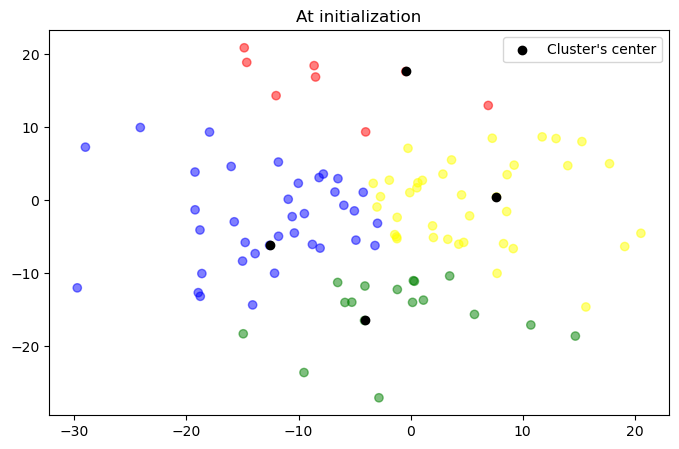

In [233]:
NB_CLUSTER = 4

X, y = make_blobs(n_samples=100, centers=NB_CLUSTER, n_features=2, cluster_std=10)
kernel = Linear()
kmean = KMEAN(Nb_cluster=NB_CLUSTER, kernel = kernel, N_iter_max=100, epsilon=1e-6, plot_init=True)

kmean.fit(X)

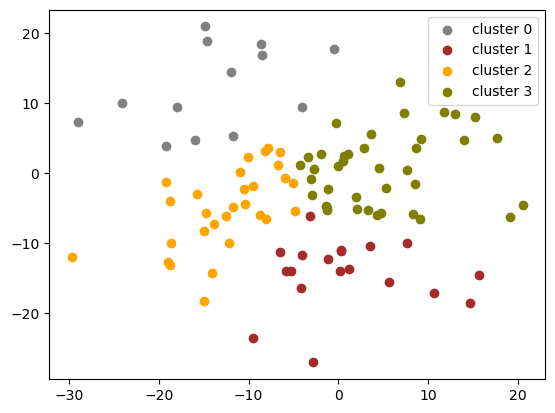

In [234]:
kmean.plot_clusters()

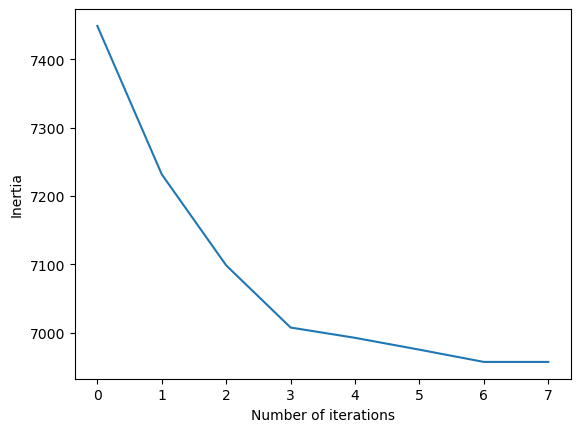

In [235]:
kmean.plot_history()

# K-Medians

It solves the same optimization problem as K-MEANS, but with $L^1$ distance rather than $L^2$ [1]. That is, it solves:
$$
\min\limits_{N_c \in \mathbb{N}^*} \min\limits_{\mathcal{C}_1, \cdots, \mathcal{C}_{N_c}} \sum_{i=1}^{N_c} \sum\limits_{x \in \mathcal{C}_i} ||x - \bar y_{i}||_1,
$$
The median is a statistical quantity less sensitive to outlier, making the cluster more robust to noise.
A variant is to rather use the geometric median, defined as:
$$
\argmin\limits_{\bar y \in \mathbb{R}^{n_d}} \sum\limits_{i = 1}^N ||x_i - \bar y||_2,
$$
to be the cluster's centroid. The objective function then becomes:
$$
\min\limits_{N_c \in \mathbb{N}^*} \min\limits_{\mathcal{C}_1, \cdots, \mathcal{C}_{N_c}} \sum_{i=1}^{N_c} \sum\limits_{x \in \mathcal{C}_i} ||x - \bar y_{i}||_2.
$$
The latter will be actually implemented, because the standard median is ill-defined in dimensions greater than $1$ by lack of strict convexity.
One applies the same strategy as in Floyd's algorithm, except that there is no closed formula to compute the update step for all dimension of space. It has to be computed via a heuristic like Simulated Annealing or Weiszfeld's algorithm [2]. For initialization, I simply use once again *kmeans++*.

Even though I coded Weiszfeld's algorithm, it does not seem to work, I can't find why. Consequently, I will employ the Simulated Annealing algorithm.

[1]https://worldcomp-proceedings.com/proc/p2015/CSC2663.pdf

[2] https://ssabach.net.technion.ac.il/files/2015/12/BS2015.pdf

In [334]:
def find_median_Simulated_Annealing(X: np.ndarray):
    """
    Find the median of a cluster with Simulated Annealing algorithm.
    """

    if len(X) == 1:
        return X

    eps=1e-10
    step = 1
    median = np.mean(X, axis=0) #Mean along the batch axis
    improved=False
    sum_dist = np.sum(np.abs(X - median))
    directions = np.eye(len(X[0]))
    while step > eps:
        for direction in directions:
            tmp_median = median + direction*step
            tmp_sum_dist = np.sum(np.abs(X - tmp_median))
            if sum_dist > tmp_sum_dist:
                sum_dist = tmp_sum_dist
                median=tmp_median
                improved=True
                break
        if not improved:
            step /= 2
        else:
            improved=False
    return median

def find_median_Weiszfeld(X):
    """
    Find the median of a cluster with Weiszfeld's algorithm. The mean of particles' set should not be confounded with any particle.
    """
    eps = 1e-10
    if len(X) == 1:
        return X

    median = np.mean(X, axis=0)

    def T(x: np.ndarray, anchors: np.ndarray[np.ndarray]):
        inv_dist = 1/np.linalg.norm(x - anchors, axis=-1)
        return np.sum(inv_dist[:,None]*anchors, axis=0)/np.sum(inv_dist)

    x0 = T(median, X)
    x1 = T(x0, X)
    while np.linalg.norm(x1-x0) > eps:
        x0 = x1
        x1 = T(x0, X)
    return x1


@dataclass
class Cluster:
    """
    Class designed to represent a cluster. A cluster is a list of variable length of particles, an Id, and the dissimilarity at its creation.
    """
    particles: np.ndarray[np.array] #key-value between particle's id and its position
    nb_particle : int
    cluster_id: int
    cluster_median: np.ndarray = None

    def fuse(self, B):
        """
        Merge two clusters into one.
        """
        for b in B.particles:
            self.particles = np.append(self.particles, [b], axis = 0)
            self.nb_particle += 1
    
    def __add__(self, P):
        """
        Add a point to the particles list.
        """
        self.particles = np.append(self.particles, P)
        self.nb_particle += 1

    def find_median_Simulated_Annealing(self):
        """
        Find the median of a cluster with Simulated Annealing algorithm.
        """
        particles = np.array([part.pos for part in self.particles])
        return find_median_Simulated_Annealing(particles)

    def find_median_Weiszfeld(self):
        """
        Find the median of a cluster with Weiszfeld's algorithm. The mean of particles' set should not be confounded with any particle.
        """
        particles = np.array([part.pos for part in self.particles])
        return find_median_Weiszfeld(particles)

    def inter_variance(self):
        """
        Compute efficiently the variance of a cluster.
        """
        return np.sum([np.linalg.norm(point.pos - self.cluster_median) for point in self.particles])

    def __iter__(self):
        self.count = 0
        return self.particles

    def __len__(self):
        return len(self.particles)

    def __next__(self):
        self.count += 1
        return self.particles[self.count - 1]

    def display(self):
        color = ["grey", "brown", "orange", "olive", "green", "cyan", "blue", 'r', 'g', 'purple']
        pos = np.array([point.pos for point in self.particles])
        try:
            plt.scatter(pos[:,0], pos[:,1], color = color[self.cluster_id], label = f'Cluster N° {self.cluster_id}')
            plt.legend()
            plt.show()
        except IndexError:
            raise ValueError("Not enough colors stored in the list.")

In [335]:
class KMEDIAN:
    """
    Class to cluster data with Kmean approach.
    Parameters:
        Nb_cluster: The number of cluster.
        kernel: the kernel function to evaluate the similarity between two points
    """
    def  __init__(self, Nb_cluster: int, N_iter_max : int, epsilon: float, plot_init: bool = False):

        self.Nb_cluster = Nb_cluster #number of cluster
        self.clusters = [] #list of clusters
        self.euclid_distance = np.linalg.norm
        self.N_iter_max = N_iter_max
        self.epsilon = epsilon
        self.plot_init = plot_init
        self.history = []
        self.is_fitter = False

    def distance(self, x: np.ndarray, y: np.ndarray):
        return self.euclid_distance(x - y)

    def dist_point_to_cluster(self, x: np.ndarray, cluster: Cluster|np.ndarray):
        """
        Compute the distance between a point x to the cluster's centroid.
        Parameters:
            x (np.ndarray): position, or an array of positions.
            cluster: Cluster object.
        Return:
            The distance between x and the cluster's centroid. If x is an arrayof points, it is vectorized.
        """
        if isinstance(cluster, Cluster):
            median = cluster.cluster_median
        elif isinstance(cluster, np.ndarray):
            median = cluster
        out = np.sum(np.linalg.norm(x - median, axis=-1), axis = 0) #Sum is useful if x is made of multiple points
        return out

    def init_points(self, X: np.ndarray):
        """
        Create a tuple of Point, one per element in X.
        """
        Points = ()
        for x in X:
            Points += (Point(x, None),)
        return Points

    def kmeans_init(self, X: np.ndarray, Points: tuple[Point]):
        """Initialize the clustering with kmean++ algorithm"""

        visited = set()

        idx_center = np.random.randint(len(X))
        center = np.array([Points[idx_center]])
        Points[idx_center].cluster_id = 0
        visited.add(idx_center)

        cluster = Cluster(center, 1, 0, cluster_median=X[idx_center])
        self.clusters.append(cluster)

        while len(self.clusters) < self.Nb_cluster:
            dist = []
            for i, x in enumerate(X):
                if i not in visited:
                    dist += [[i,min([self.dist_point_to_cluster(x, cluster) for cluster in self.clusters])]]
            
            list_dist = np.array(dist)[:,1]
            list_dist /= np.sum(list_dist)

            k = np.random.multinomial(1,list_dist) #Sample a random number between 1 and len(list_dist)

            id_ = np.where(k == 1)[0]
            idx_x = np.array(dist)[id_, 0].astype(int).item()
            visited.add(idx_x)
            
            center = np.array([Points[idx_x]])
            Points[idx_x].cluster_id = len(cluster)
            cluster = Cluster(center, 1, len(self.clusters), cluster_median=X[idx_x])
            self.clusters.append(cluster)

        if self.plot_init:
            plt.figure(figsize = (8,5))
            center = np.array([c.particles[0].pos for c in self.clusters])
            color = np.array(['red', 'green', 'blue', 'yellow', 'brown', "cyan"])
            y = self.predict(X)
            plt.scatter(X[:,0], X[:,1], color = color[y], alpha = .5)
            plt.scatter(center[:,0], center[:,1], color = 'black', label = "Cluster's center")
            plt.title("At initialization")
            plt.legend()

    def compute_clusters_median(self):
        """
        Compute the mediane centre of each cluster.
        """
        for c in self.clusters:
            c.cluster_mediane = c.find_median_Simulated_Annealing()

    def fit(self, X: np.ndarray):
        """Create cluster with Lloyd's algorithm. Initialization done with Kmeans ++
            Args:
                X (np.ndarray): dataset.
            Returns:
                A set of cluster.
        """
        
        Points = self.init_points(X)
        self.kmeans_init(X, Points)
        
        self.compute_clusters_median()

        Q = np.infty
        Qold = 0
        counter_iter=0
        while np.abs(Q - Qold) > self.epsilon and counter_iter < self.N_iter_max:
            clusters = [[] for _ in range(self.Nb_cluster)]
            for point in Points: #Could be improved with vectorization
                argmin = np.argmin([self.dist_point_to_cluster(point.pos, cluster) for cluster in self.clusters], axis=-1) #Compute distance between point and cluster
                clusters[argmin].append(point)
                point.cluster_id=argmin
            
            sum = 0
            for cluster in clusters:
                pos = np.array([part.pos for part in cluster])
                median = find_median_Simulated_Annealing(X)
                sum += np.sum([self.dist_point_to_cluster(pos, median)])

            #Update clusters
            for i in range(self.Nb_cluster):
                self.clusters[i].particles = np.array(clusters[i])
                self.clusters[i].nb_particle = len(clusters[i])
            self.compute_clusters_median() #Update clusters' median

            Qold = Q
            Q = sum
            self.history.append(self.inertia())
            counter_iter += 1
        self.is_fitted = True

    def predict(self, X_test: np.ndarray[np.ndarray]):
        dist_ = []
        for x in X_test:
            ag_min = np.argmin([self.dist_point_to_cluster(x, c)for c in self.clusters])
            dist_.append(self.clusters[ag_min].cluster_id)
        return dist_

    def plot_clusters(self, ax = None):
        """
        Plot clusters with assigned index.
        ax: Axis on which to plot on.
        """
        assert self.is_fitted, "You did not fit your data set yet."

        color = ["grey", "brown", "orange", "olive", "green", "cyan", "blue"]

        if ax is not None:
            for i, c in enumerate(self.clusters):
                particles = np.array([part.pos for part in c.particles])
                ax.scatter(c.particles[:,0], c.particles[:,1], color = color[i], label = f'cluster {i}')
            ax.legend()
            plt.show()
        else:
            for i, c in enumerate(self.clusters):
                particles = np.array([part.pos for part in c.particles])
                plt.scatter(particles[:,0], particles[:,1], color = color[i], label = f'cluster {i}')
                plt.legend()
            plt.show()

    def inertia(self) -> int:
        """
        Compute the inertia of the set of cluster.
        """
        val = 0
        for c in self.clusters:
            val += c.inter_variance()
        return val

    def plot_history(self):
        plt.plot(self.history)
        plt.xlabel("Number of iterations")
        plt.ylabel("Inertia")
        plt.show()

## Example

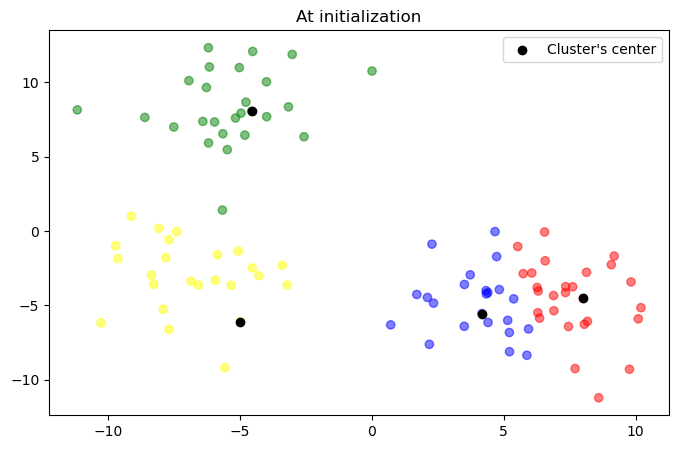

In [336]:
NB_CLUSTER = 4

X, y = make_blobs(n_samples=100, centers=NB_CLUSTER, n_features=2, cluster_std=2)
kernel = Linear()
kmedian = KMEDIAN(Nb_cluster=NB_CLUSTER, N_iter_max=100, epsilon=1e-6, plot_init=True)

kmedian.fit(X)

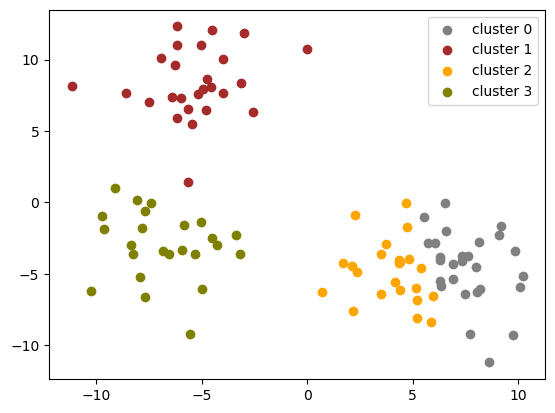

In [337]:
kmedian.plot_clusters()

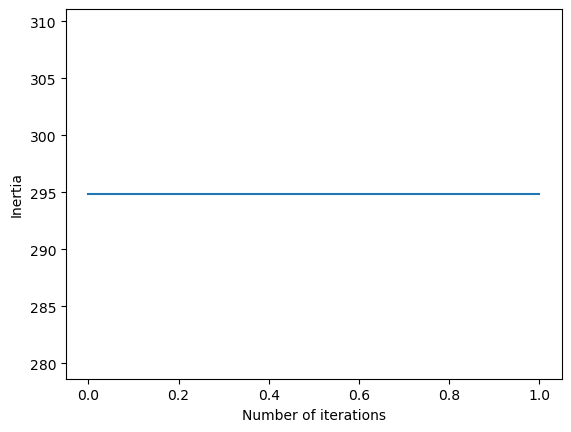

In [338]:
kmedian.plot_history()

### Example Where Weiszfeld's algorithm does not work.

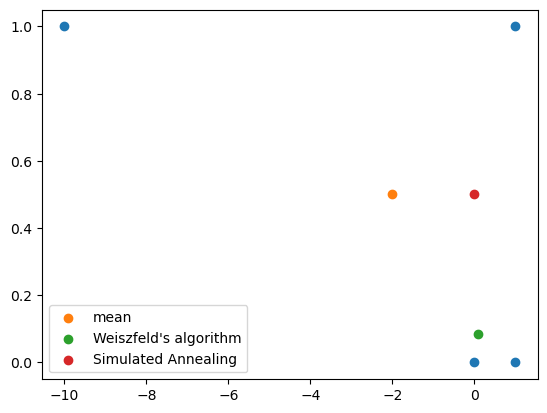

In [343]:
X = np.array([[1, 0], [0, 0] ,[-10, 1], [1, 1]])
c = Cluster(X, 4, 0)
med = find_median_Weiszfeld(X)
med2 = find_median_Simulated_Annealing(X)
mean = np.mean(X, axis=0)

plt.scatter(X[:,0], X[:, 1])
plt.scatter(mean[0], mean[1], label="mean")
plt.scatter(med[0], med[1], label="Weiszfeld's algorithm")
plt.scatter(med2[0], med2[1], label="Simulated Annealing")
plt.legend()
plt.show()

# Mean Shift

The core idea of the algorithm is to find the modes of the underlying probability distribution, that is, the regions of highest densities. Starting from a (random) initialization, it shifts iteration after iteration the mean to make converge towards a peak. It is used in computer vision for image segmentation.